# FINAL Project: Modelling Google's Share Price

In [1]:
# load packages
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from datetime import timedelta
import statsmodels
from statsmodels.tsa.stattools import adfuller
import scipy.signal
import statsmodels.api as sm
from statsmodels.tsa.stattools import pacf
from statsmodels.graphics.tsaplots import plot_pacf
import itertools
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt


%matplotlib inline

In [2]:
# set figure size
mpl.rcParams['figure.figsize'] = 17,6

In [3]:
# read file
goog = pd.read_csv('goog10yr.csv')
goog.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
2513,2018-12-17,1037.510010,1053.150024,1007.900024,1016.530029,1016.530029,2385400
2514,2018-12-18,1026.089966,1049.479980,1021.440002,1028.709961,1028.709961,2192500
2515,2018-12-19,1033.989990,1062.000000,1008.049988,1023.010010,1023.010010,2479300
2516,2018-12-20,1018.130005,1034.219971,996.359985,1009.409973,1009.409973,2673500
2517,2018-12-21,1015.299988,1024.020020,973.690002,979.539978,979.539978,4562700


In [4]:
# dimension
goog.shape

(2518, 7)

In [5]:
# rename columns, index date
goog.rename(columns={'Date':'date','Open':'open','High':'high','Low':'low','Close':'close','Adj Close':'adjc','Volume':'vol'}, inplace = True)
goog.columns

Index(['date', 'open', 'high', 'low', 'close', 'adjc', 'vol'], dtype='object')

In [6]:
# descriptive stats
print(goog.describe())
print(goog.dtypes)

              open         high          low        close         adjc  \
count  2518.000000  2518.000000  2518.000000  2518.000000  2518.000000   
mean    544.242343   548.814343   539.313984   544.155828   544.155828   
std     290.999783   293.483720   288.395725   290.958307   290.958307   
min     143.243347   148.782318   140.461441   140.461441   140.461441   
25%     292.477722   294.365448   289.560440   291.918853   291.918853   
50%     513.846374   518.150818   509.968522   513.483459   513.483459   
75%     750.089982   756.944993   743.227509   749.977493   749.977493   
max    1271.000000  1273.890015  1249.020020  1268.329956  1268.329956   

                vol  
count  2.518000e+03  
mean   3.883268e+06  
std    3.070627e+06  
min    7.900000e+03  
25%    1.611025e+06  
50%    3.231000e+06  
75%    5.114350e+06  
max    2.984230e+07  
date      object
open     float64
high     float64
low      float64
close    float64
adjc     float64
vol        int64
dtype: object


In [7]:
# null values?
goog.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2518 entries, 0 to 2517
Data columns (total 7 columns):
date     2518 non-null object
open     2518 non-null float64
high     2518 non-null float64
low      2518 non-null float64
close    2518 non-null float64
adjc     2518 non-null float64
vol      2518 non-null int64
dtypes: float64(5), int64(1), object(1)
memory usage: 137.8+ KB


In [8]:
# date format & sort
goog['date'] = pd.to_datetime(goog['date'])
goog.sort_values(by='date')
goog.head()

,date,open,high,low,close,adjc,vol
0,2008-12-22,153.283035,153.750000,144.375977,147.595032,147.595032,7886100
1,2008-12-23,149.244308,150.675003,147.376465,148.047104,148.047104,7604400
2,2008-12-24,149.765915,152.180222,148.225937,150.496170,150.496170,3867900
3,2008-12-26,151.052551,151.643707,148.191162,149.209534,149.209534,3943600
4,2008-12-29,149.139984,149.716248,144.847900,147.749039,147.749039,7451900


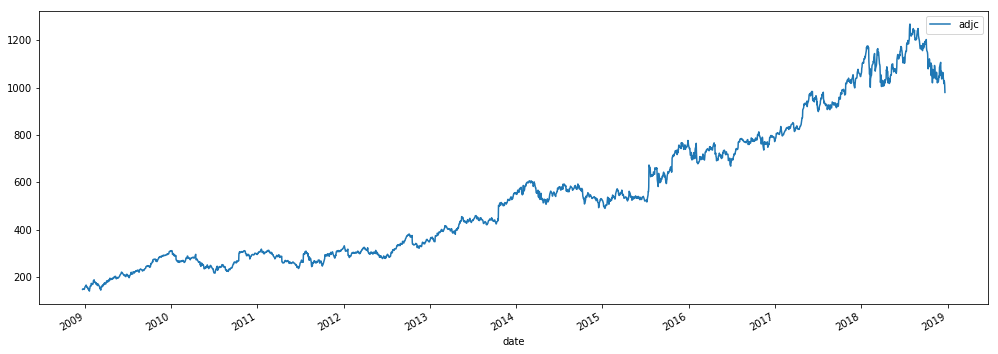

In [9]:
# plot by years
googyr = goog.groupby(goog.date).mean()
googyr.plot(y = 'adjc')

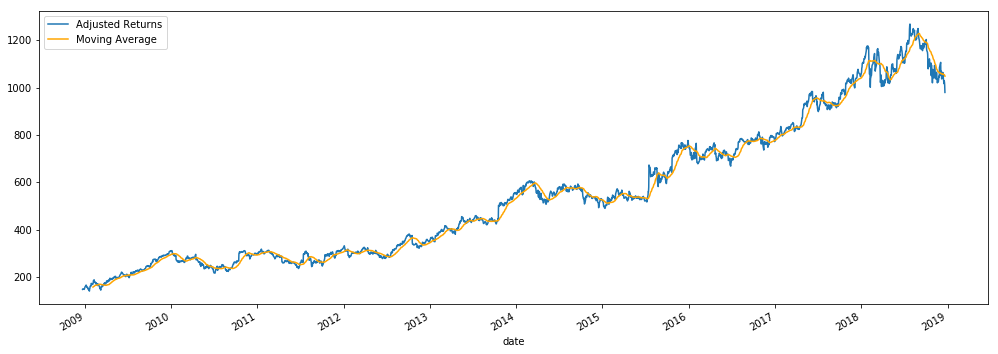

In [10]:
# 30day moving average
googyr['mva'] = googyr['adjc'].rolling(window=30).mean()
# plot 
googyr.plot(y = 'adjc')
googyr['mva'].plot(c = 'orange')
plt.legend(labels = ['Adjusted Returns','Moving Average'])
plt.show()

In [11]:
# polynomial fit
fit1st = np.polyfit(goog.index,goog['adjc'],1)
fit2nd = np.polyfit(goog.index,goog['adjc'],2)
poly1st = np.poly1d(fit1st)
poly2nd = np.poly1d(fit2nd)
print(fit1st)
print(fit2nd)

[ 0.38236033 62.95534982]
[1.50464930e-04 3.64010302e-03 2.21765366e+02]


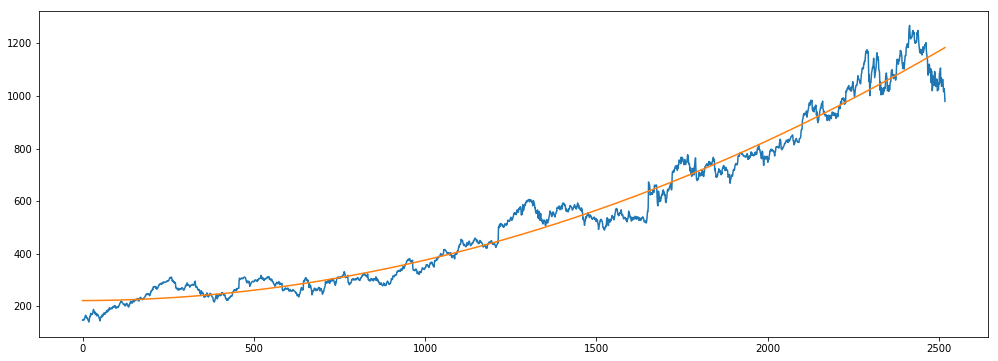

In [12]:
# Plot the time series.
plt.plot(goog.index, goog['adjc'])
# Plot the least squares minimizing line.
plt.plot(goog.index, poly2nd(goog.index))

In [13]:
# set index
goog.set_index('date', inplace = True)
# setup year & month
goog['yr'] = goog.index.year
goog['mnth'] = goog.index.month
goog.tail()

,open,high,low,close,adjc,vol,yr,mnth
date,,,,,,,,
2018-12-17,1037.510010,1053.150024,1007.900024,1016.530029,1016.530029,2385400,2018,12
2018-12-18,1026.089966,1049.479980,1021.440002,1028.709961,1028.709961,2192500,2018,12
2018-12-19,1033.989990,1062.000000,1008.049988,1023.010010,1023.010010,2479300,2018,12
2018-12-20,1018.130005,1034.219971,996.359985,1009.409973,1009.409973,2673500,2018,12
2018-12-21,1015.299988,1024.020020,973.690002,979.539978,979.539978,4562700,2018,12


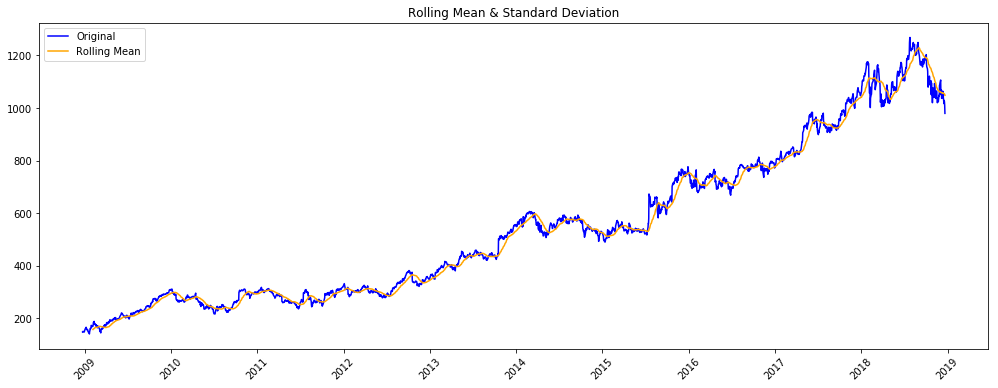

Results of Dickey-Fuller Test:
Test Statistic                   -0.326492
p-value                           0.921668
#Lags Used                       24.000000
Number of Observations Used    2493.000000
Critical Value (1%)              -3.432976
Critical Value (5%)              -2.862700
Critical Value (10%)             -2.567388
dtype: float64


In [14]:
# define function to test for stationarity
def test_stationarity(timeseries):
    
    # Determining 30day rolling statistics:
    rolmean = timeseries.rolling(30).mean()
    rolstd = timeseries.rolling(30).std()
    
    # Plotting rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='orange', label='Rolling Mean')
#     std = plt.plot(rolstd, color='orange', label = 'Rolling Std')
    plt.xticks(rotation=45)
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Performing the Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
test_stationarity(goog.adjc)

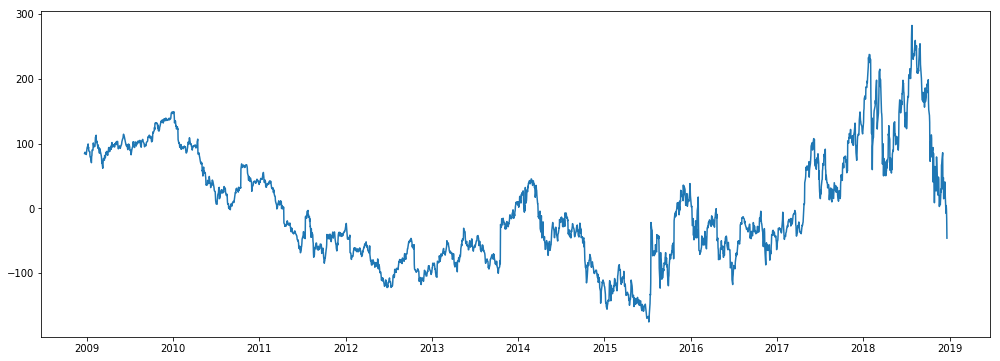

In [15]:
# p-value is high; unable to reject the null; data is non-stationary; detrending is required
detrd = scipy.signal.detrend(goog.adjc.values)
plt.plot(goog.index, detrd)

## Defining Train & Test Sets

In [16]:
detrd = pd.DataFrame(detrd, columns = ['adjc'])
detrd = (goog['yr'].reset_index()).join(detrd)
detrd.rename(columns={'0':'adjc'}, inplace = True)
detrd.head()

,date,yr,adjc
0,2008-12-22,2008,84.639682
1,2008-12-23,2008,84.709394
2,2008-12-24,2008,86.776100
3,2008-12-26,2008,85.107103
4,2008-12-29,2008,83.264248


In [17]:
# define test & train sets
train = detrd[(detrd['yr'] >= 2009) & (detrd['yr'] <= 2013)]
test = detrd[(detrd['yr'] >= 2014) & (detrd['yr'] <= 2018)]

## Autocorrelation

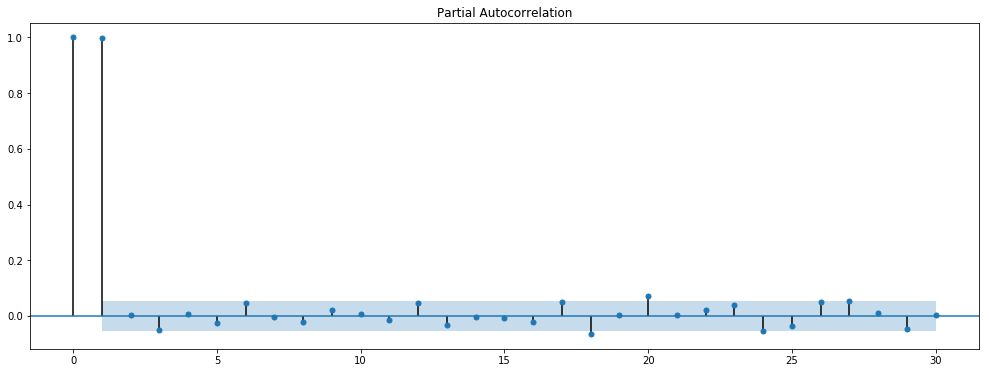

In [18]:
# partial autocorrelation
plot_pacf(train.adjc.values, lags=30, alpha =.05)
plt.show()

## Method 1: Naive Approach

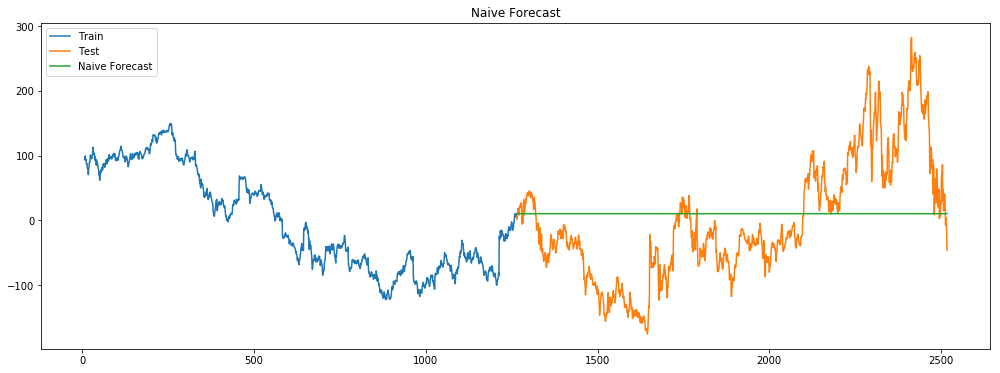

In [19]:
# Naive Approach
dd = np.asarray(train.adjc)
y_hat = test.copy()
y_hat['naive'] = dd[len(dd)-1]
plt.plot(train['adjc'], label='Train')
plt.plot(test['adjc'], label='Test')
plt.plot(y_hat['naive'], label='Naive Forecast')
plt.legend(loc='best')
plt.title("Naive Forecast")
plt.show()
mse_naive = sqrt(mean_squared_error(test.adjc, y_hat.naive))

## Method 2: Simple Moving Average

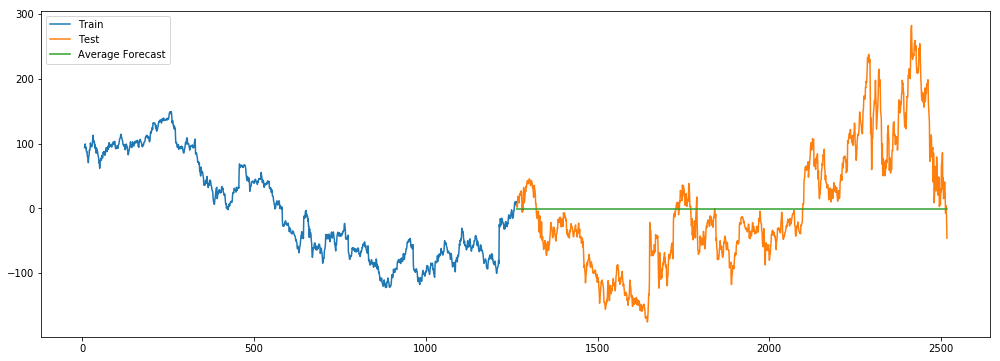

In [20]:
# SMA
y_hat_avg = test.copy()
y_hat_avg['avg_forecast'] = train['adjc'].mean()
plt.plot(train['adjc'], label='Train')
plt.plot(test['adjc'], label='Test')
plt.plot(y_hat_avg['avg_forecast'], label='Average Forecast')
plt.legend(loc='best')
plt.show()
mse_sma = sqrt(mean_squared_error(test.adjc, y_hat_avg.avg_forecast))

## Method 3: Moving Average

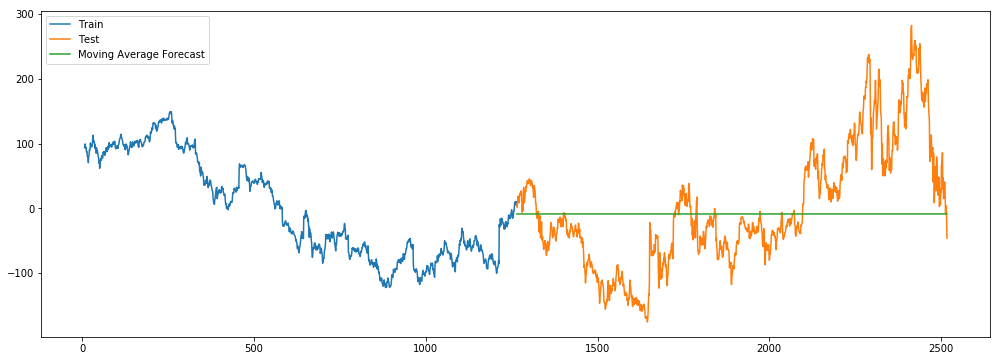

In [21]:
# Moving Average
y_hat_avg = test.copy()
y_hat_avg['moving_avg_forecast'] = train['adjc'].rolling(30).mean().iloc[-1]
plt.plot(train['adjc'], label='Train')
plt.plot(test['adjc'], label='Test')
plt.plot(y_hat_avg['moving_avg_forecast'], label='Moving Average Forecast')
plt.legend(loc='best')
plt.show()
mse_ma = sqrt(mean_squared_error(test.adjc, y_hat_avg.moving_avg_forecast))

## Method 4: Simple Exponential Smoothing

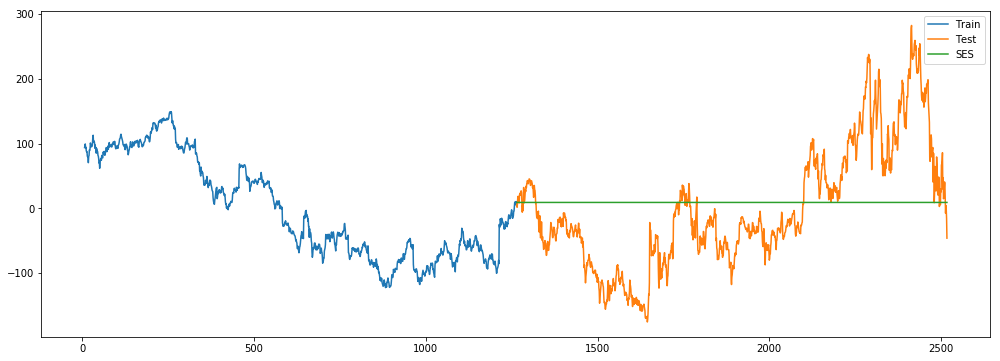

In [22]:
# simple exponential smoothing
y_hat_avg = test.copy()
fit2 = SimpleExpSmoothing(np.asarray(train['adjc'])).fit(smoothing_level=0.7,optimized=False)
y_hat_avg['SES'] = fit2.forecast(len(test))
plt.plot(train['adjc'], label='Train')
plt.plot(test['adjc'], label='Test')
plt.plot(y_hat_avg['SES'], label='SES')
plt.legend(loc='best')
plt.show()
mse_ses = sqrt(mean_squared_error(test.adjc, y_hat_avg.SES))

## Method 5: Holt's Linear Trend

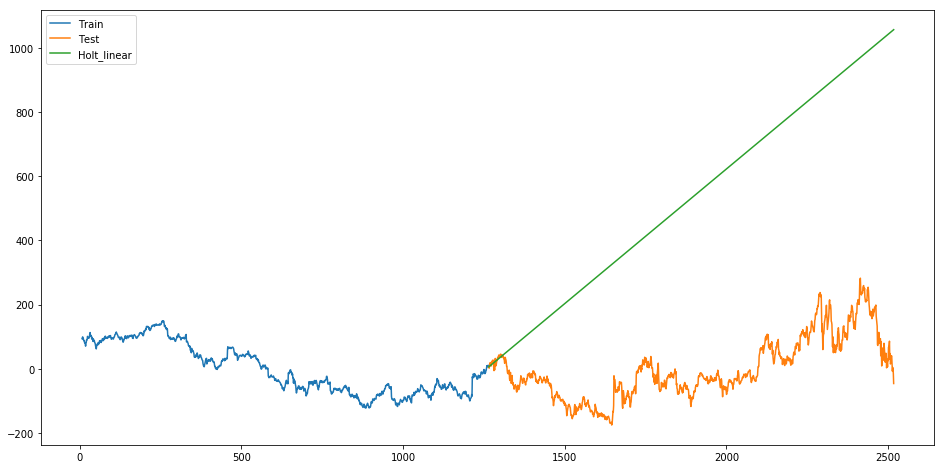

In [23]:
# holt
y_hat_avg = test.copy()
fit1 = Holt(np.asarray(train['adjc'])).fit(smoothing_level = 0.1,smoothing_slope = 0.1)
y_hat_avg['Holt_linear'] = fit1.forecast(len(test))
plt.figure(figsize=(16,8))
plt.plot(train['adjc'], label='Train')
plt.plot(test['adjc'], label='Test')
plt.plot(y_hat_avg['Holt_linear'], label='Holt_linear')
plt.legend(loc='best')
plt.show()
mse_holt = sqrt(mean_squared_error(test.adjc, y_hat_avg.Holt_linear))

## Method 6: Holt Winter

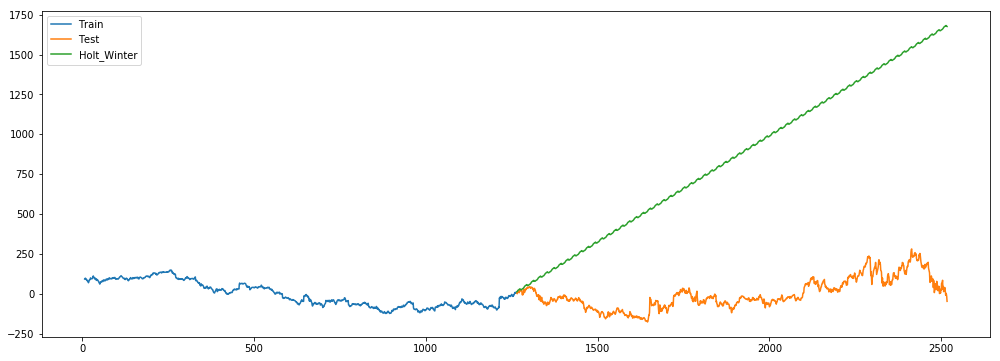

In [24]:
# holt winter
y_hat_avg = test.copy()
fit1 = ExponentialSmoothing(np.asarray(train['adjc']) ,seasonal_periods=20 ,trend='add', seasonal='add',).fit()
y_hat_avg['Holt_Winter'] = fit1.forecast(len(test))
plt.plot( train['adjc'], label='Train')
plt.plot(test['adjc'], label='Test')
plt.plot(y_hat_avg['Holt_Winter'], label='Holt_Winter')
plt.legend(loc='best')
plt.show()
mse_holtw = sqrt(mean_squared_error(test.adjc, y_hat_avg.Holt_Winter))

## Method 7: ARIMA

In [ ]:
# finding optimal pdqs values
p = d = q = range(2, 4)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 20) for x in list(itertools.product(p, d, q))]
aic = 50000
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train.adjc,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            if results.aic < aic:
                aic = results.aic
                print('ARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

/Users/subodh/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/subodh/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 2, 2)x(2, 2, 2, 20) - AIC:7272.499419256475


/Users/subodh/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/subodh/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 2, 2)x(2, 2, 3, 20) - AIC:7147.092033717832


/Users/subodh/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/subodh/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/subodh/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/subodh/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/subodh/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarnin

ARIMA(2, 2, 3)x(2, 2, 3, 20) - AIC:7143.493429325081


/Users/subodh/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/subodh/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/subodh/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/subodh/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/subodh/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarnin

/Users/subodh/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/subodh/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/subodh/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/subodh/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/subodh/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning:

/Users/subodh/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/subodh/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/subodh/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/subodh/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/subodh/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarnin

/Users/subodh/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/subodh/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


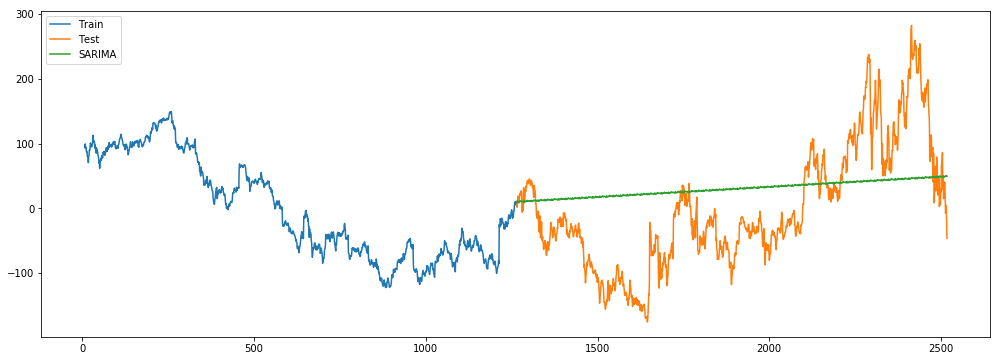

In [36]:
## ARIMA
y_hat_avg = test.copy()
fit1 = sm.tsa.statespace.SARIMAX(train.adjc, order=(0,1,2),seasonal_order=(1,1,2,20)).fit()
y_hat_avg['SARIMA'] = fit1.predict(start=1258, end=28000, dynamic=True)
plt.plot(train['adjc'], label='Train')
plt.plot(test['adjc'], label='Test')
plt.plot(y_hat_avg['SARIMA'], label='SARIMA')
plt.legend(loc='best')
plt.show()
mse_arima = sqrt(mean_squared_error(test.adjc, y_hat_avg.SARIMA))

## Comparing MSE

In [37]:
# Print MSE
print("Naive Method Root Mean Squared Error:",mse_naive)
print("Simple Moving Average Method Root Mean Squared Error:",mse_sma)
print("Moving Average Root Mean Squared Error:",mse_ma)
print("Simple Exponential Smoothing Root Mean Squared Error:",mse_ses)
print("Holt's Linear Trend Root Mean Squared Error:",mse_holt)
print("Holt Winter Root Mean Squared Error:",mse_holtw)
print("ARIMA Root Mean Squared Error:",mse_arima)

Naive Method Root Mean Squared Error: 95.10628820710103
Simple Moving Average Method Root Mean Squared Error: 94.57231075218448
Moving Average Root Mean Squared Error: 94.97344975746037
Simple Exponential Smoothing Root Mean Squared Error: 94.99054532970445
Holt's Linear Trend Root Mean Squared Error: 585.4693850016415
Holt Winter Root Mean Squared Error: 945.8678940230069
ARIMA Root Mean Squared Error: 91.90943842237132


In [38]:
print(min(("Naive Method Root Mean Squared Error:",mse_naive),
          ("Simple Moving Average Method Root Mean Squared Error:",mse_sma),
          ("Moving Average Root Mean Squared Error:",mse_ma),
          ("Simple Exponential Smoothing Root Mean Squared Error:",mse_ses),
          ("Holt's Linear Trend Root Mean Squared Error:",mse_holt),
          ("Holt Winter Root Mean Squared Error:",mse_holtw),
          ("ARIMA Root Mean Squared Error:",mse_arima)))

('ARIMA Root Mean Squared Error:', 91.90943842237132)


# ARIMA proves to have the lowest RMSE